In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from arviz import plot_posterior
from scipy.optimize import newton


Lets import our tumor data

In [2]:
df = pd.read_csv('tumor.csv')
df.head()


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,worst_area,smoothness_mean,compactness_mean,fractal_dimension_worst,smoothness_worst,...,compactness_worst,smoothness_se,concave points_worst,concavity_se,concave points_se,concavity_worst,fractal_dimension_se,radius_worst,symmetry_worst,perimeter_worst
0,842302,M,17.99,10.38,122.80,2019.0,0.11840,0.27760,0.11890,0.1622,...,0.6656,0.006399,0.2654,0.05373,0.01587,0.7119,0.006193,25.38,0.4601,184.60
1,842517,M,20.57,17.77,132.90,1956.0,0.08474,0.07864,0.08902,0.1238,...,0.1866,0.005225,0.1860,0.01860,0.01340,0.2416,0.003532,24.99,0.2750,158.80
2,84300903,M,19.69,21.25,130.00,1709.0,0.10960,0.15990,0.08758,0.1444,...,0.4245,0.006150,0.2430,0.03832,0.02058,0.4504,0.004571,23.57,0.3613,152.50
3,84348301,M,11.42,20.38,77.58,567.7,0.14250,0.28390,0.17300,0.2098,...,0.8663,0.009110,0.2575,0.05661,0.01867,0.6869,0.009208,14.91,0.6638,98.87
4,84358402,M,20.29,14.34,135.10,1575.0,0.10030,0.13280,0.07678,0.1374,...,0.2050,0.011490,0.1625,0.05688,0.01885,0.4000,0.005115,22.54,0.2364,152.20


array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'radius_mean'}>,
        <AxesSubplot:title={'center':'texture_mean'}>,
        <AxesSubplot:title={'center':'perimeter_mean'}>,
        <AxesSubplot:title={'center':'worst_area'}>],
       [<AxesSubplot:title={'center':'smoothness_mean'}>,
        <AxesSubplot:title={'center':'compactness_mean'}>,
        <AxesSubplot:title={'center':'fractal_dimension_worst'}>,
        <AxesSubplot:title={'center':'smoothness_worst'}>,
        <AxesSubplot:title={'center':'symmetry_mean'}>],
       [<AxesSubplot:title={'center':'fractal_dimension_mean'}>,
        <AxesSubplot:title={'center':'radius_se'}>,
        <AxesSubplot:title={'center':'texture_se'}>,
        <AxesSubplot:title={'center':'perimeter_se'}>,
        <AxesSubplot:title={'center':'compactness_worst'}>],
       [<AxesSubplot:title={'center':'smoothness_se'}>,
        <AxesSubplot:title={'center':'concave points_worst'}>,
        <AxesSubplot:title={'ce

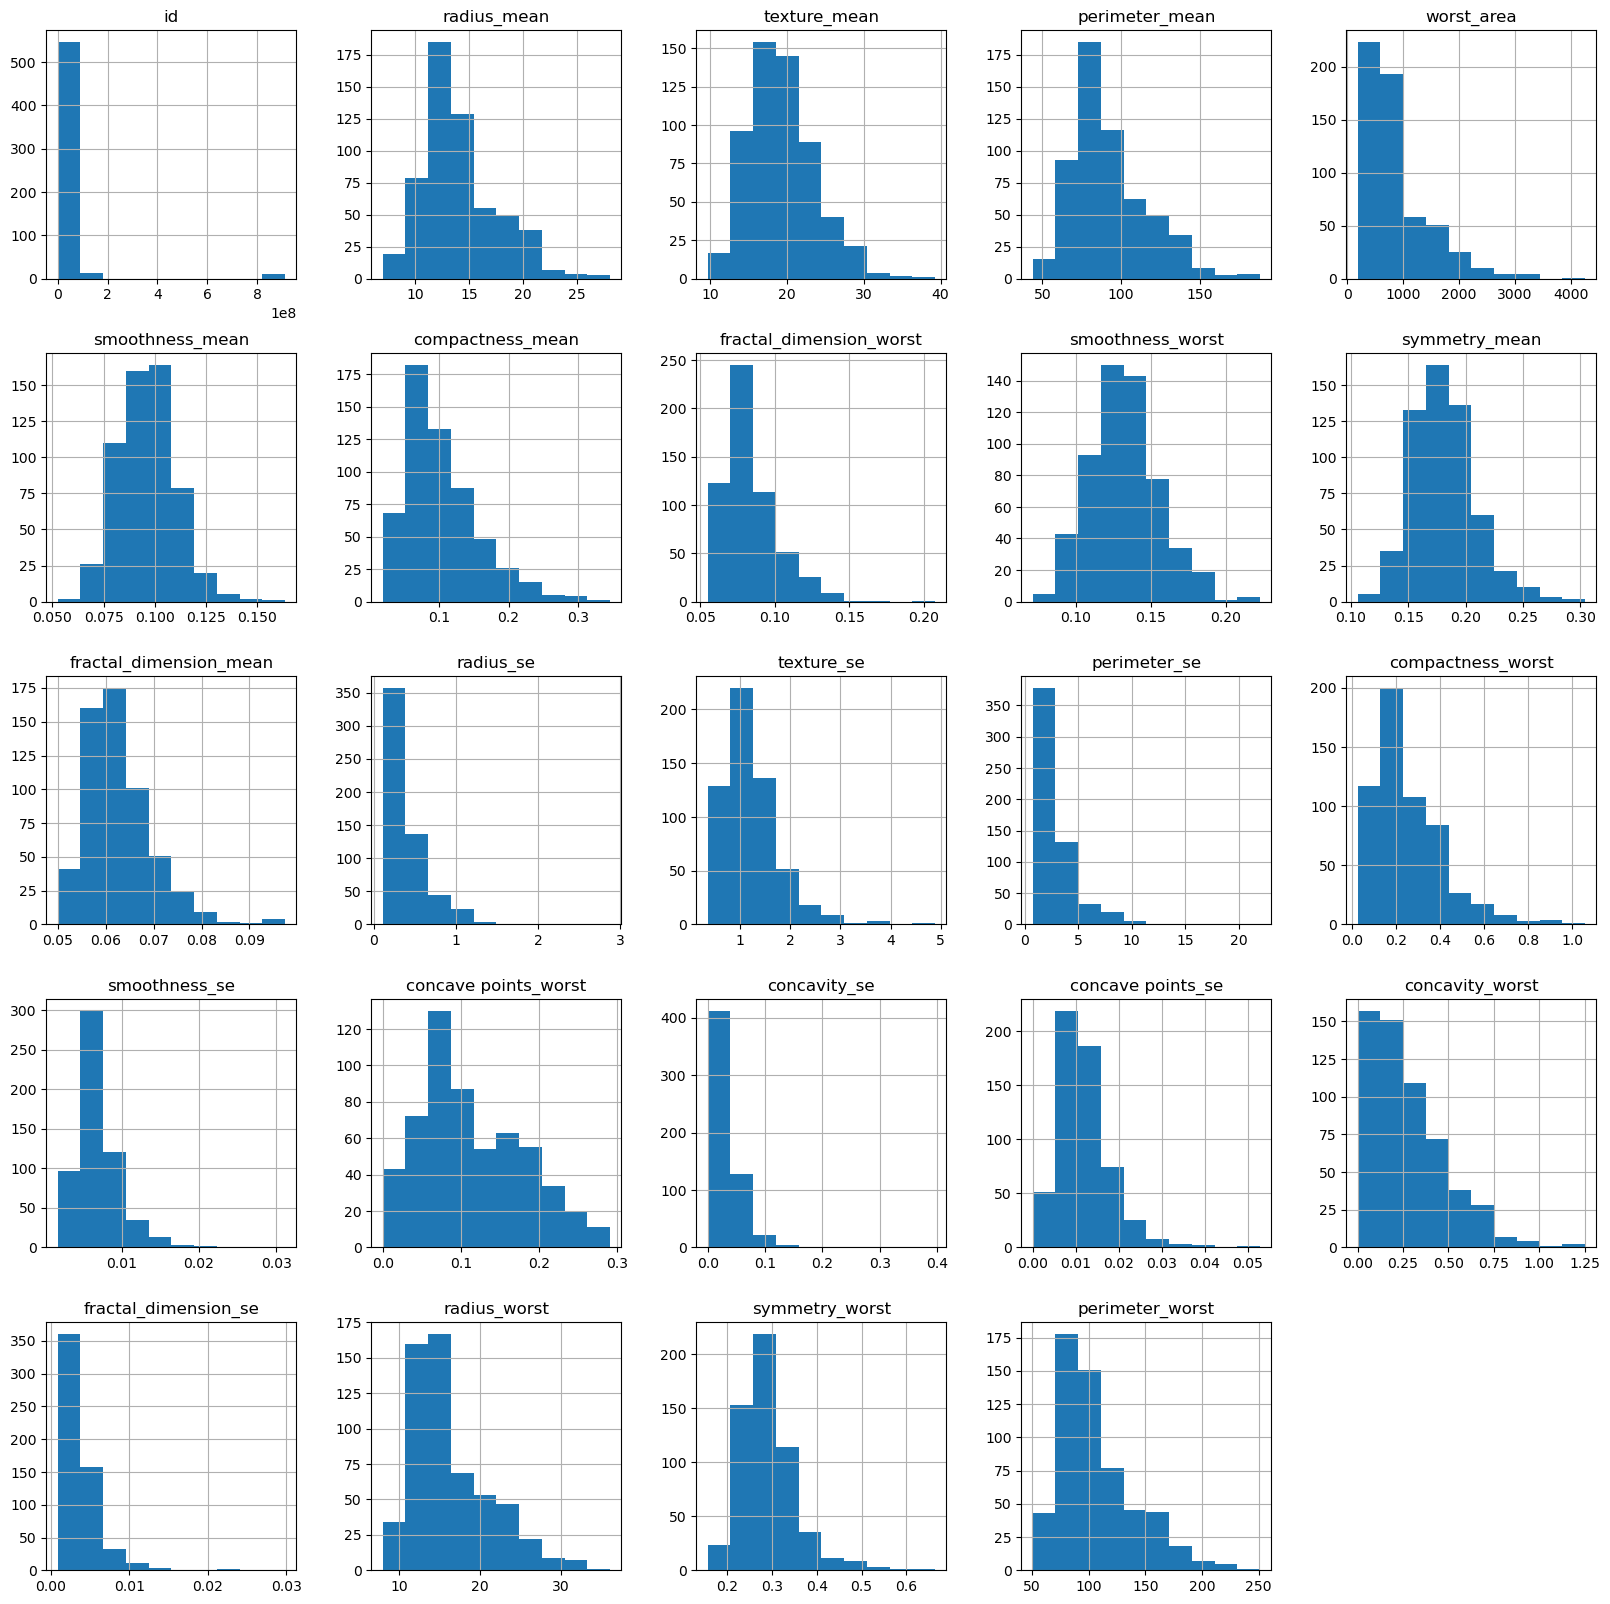

In [3]:
df.hist(figsize=(20,20))

Considering worst area

### WORST AREA

<AxesSubplot:xlabel='worst_area', ylabel='Count'>

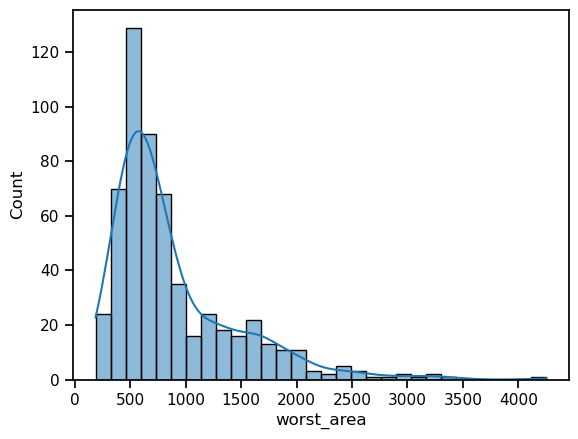

In [4]:
import seaborn as sns
sns.set_context('notebook')

worst_area = df['worst_area']
sns.histplot(worst_area, bins=30, kde=True)

In [5]:
worst_area.skew()

1.8593732724433467

In [6]:
worst_area.describe()

count     569.000000
mean      880.583128
std       569.356993
min       185.200000
25%       515.300000
50%       686.500000
75%      1084.000000
max      4254.000000
Name: worst_area, dtype: float64

### Maximum likelihood estimation
---

In [7]:
smean = worst_area.mean()
rate = 1. / smean
print("Rate parameter is : ", rate)

Rate parameter is :  0.0011356111284302347


In [8]:
# calculating the sample min and max
smax = worst_area.max()
smin = worst_area.min()
vals = np.linspace(smin, smax, 1000)
# bin size: interval between two consecutive values in `days`
dt = smax / 999.

In [9]:
import scipy.stats as st

#modeling the exponential distrubution with the derived rate parameter
dist_exp = st.expon.pdf(vals, scale=1. / rate)

Text(0, 0.5, 'Frequency')

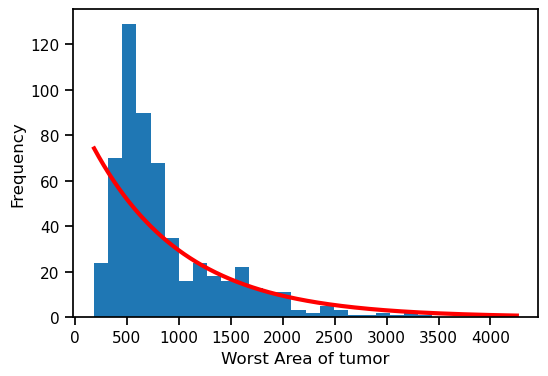

In [10]:
nbins = 30
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(worst_area, nbins)
ax.plot(vals, dist_exp * len(worst_area) * smax / nbins,
        '-r', lw=3)
ax.set_xlabel("Worst Area of tumor")
ax.set_ylabel("Frequency")

In [11]:
dist = st.expon
args = dist.fit(worst_area)
args

(185.2, 695.3831282952549)

In [12]:
st.kstest(worst_area, dist.cdf, args)

KstestResult(statistic=0.16630575287243746, pvalue=3.1877115740468606e-14)

### Bayesian simulations

In [13]:
from pymc3 import Model, Uniform, Exponential

#starting off with a uniform distribution
with Model() as cancer_model:
    lambda_prior = Uniform('lambda', lower = 0, upper =10)

In [14]:
# generate the model as exponential distribution
with cancer_model:
    bayesian_model = Exponential('bayesian_model', 1/lambda_prior, observed=worst_area)

In [15]:
# start off with a random seed and run 1000 simulations to get the right fit!
RANDOM_SEED = 20090425

from pymc3 import fit

with cancer_model: 
    cancer_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 54,940


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/komal_albhar/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


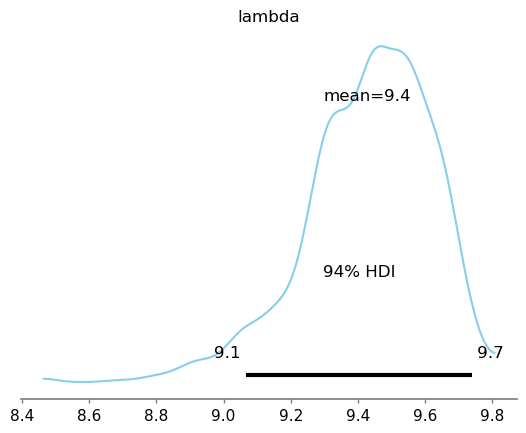

In [16]:
from pymc3 import plot_posterior
from arviz import plot_posterior

plot_posterior(cancer_trace[100:], 
                var_names=['lambda'],
                color='#87ceeb');